# Tweet sentimnet

In [1]:
import pandas as pd
import os
import json
import numpy as np
import matplotlib
from textblob import TextBlob
from collections import defaultdict
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import spacy
from spacy import displacy
import re 
from urllib.parse import urlparse
import http.client as httplib
import urllib.parse as urlp
from tqdm.notebook import tqdm
from textstat import flesch_reading_ease
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize
import pyLDAvis.gensim
import gensim
from wordcloud import WordCloud, STOPWORDS
from bs4 import BeautifulSoup
import iso639
from googletrans import Translator

/Users/tomashegewisch/research_project/Tomas/env/lib/python3.7/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [2]:
path = "./hydrated/"
files = os.listdir(path)
tweets = []
for i in files:
    if i == ".DS_Store" or i == ".ipynb_checkpoints":
        continue
    tweets_per_file = []
    with open(path+i, 'r') as read:
        tweets_per_file = json.loads(read.read())
    for j in tweets_per_file:
        tweets.append(j)
print(len(tweets))
#tweets to a dataframe
df = pd.DataFrame (tweets)
df.head()

7984


,created_at,id,id_str,full_text,truncated,display_text_range,entities,source,in_reply_to_status_id,in_reply_to_status_id_str,...,favorited,retweeted,lang,extended_entities,possibly_sensitive,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_status,withheld_in_countries
0,Wed Apr 29 12:12:11 +0000 2020,1255469930574761990,1255469930574761990,RT @gerardotc: Me he puesto un rato a Jiménez ...,False,"[0, 139]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/android"" ...",NaN,None,...,False,False,es,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Wed Apr 29 16:23:28 +0000 2020,1255533168310050816,1255533168310050816,RT @LilBlondie45: Anyone seeing hundreds of pp...,False,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/iphone"" r...",NaN,None,...,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Wed Apr 29 13:09:16 +0000 2020,1255484293725458433,1255484293725458433,RT @USMCSDI: Shutting down America over virus ...,False,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/android"" ...",NaN,None,...,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Wed Apr 29 19:56:09 +0000 2020,1255586689977909248,1255586689977909248,RT @Italialibera6: @GiuseppeConteIT 🔴President...,False,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/android"" ...",NaN,None,...,False,False,it,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Wed Apr 29 16:52:51 +0000 2020,1255540563501350912,1255540563501350912,RT @JamilChade: A curva do vírus \n\n(confesso...,False,"[0, 109]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/android"" ...",NaN,None,...,False,False,pt,"{'media': [{'id': 1255523089976303624, 'id_str...",False,NaN,NaN,NaN,NaN,NaN


# Below is the average number of characters in the text

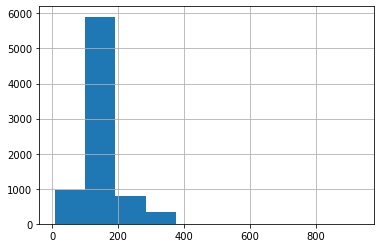

In [3]:
df['full_text'].str.len().hist()

# Sentiment

In [4]:
#this is probably not very usefull.... at all
polarity = 0
list_of_tweets = df['full_text'].tolist()
for i in list_of_tweets:
    polarity += TextBlob(i).sentiment.polarity
round(polarity/len(list_of_tweets)*100)/100

0.03

Looks likes the majority is in the positive... well just over


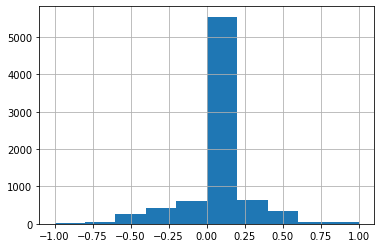

In [5]:
def get_sent(text):
    return TextBlob(text).sentiment.polarity

tweet_senti_values = df['full_text'].apply(lambda x : get_sent(x))
tweet_senti_values.hist()
print("Looks likes the majority is in the positive... well just over")

can we assume that this is wrong


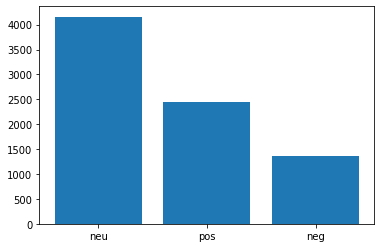

In [6]:
def sentiment(x):
    if x<0:
        return 'neg'
    elif x==0:
        return 'neu'
    else:
        return 'pos' 
    
tweet_senti_values_polarity = tweet_senti_values.map(lambda x: sentiment(x))
#tweet_senti_values_polarity.head()
plt.bar(tweet_senti_values_polarity.value_counts().index, tweet_senti_values_polarity.value_counts()) 
print("can we assume that this is wrong")

In [7]:
def get_sent(text):
    return TextBlob(text).sentiment.polarity
for i in df["full_text"].tolist()[:4]:
    if get_sent(i) <= 0:
        print(i)
        print("___________")

RT @gerardotc: Me he puesto un rato a Jiménez Losantos para descubrir verdades que me oculta el Gobierno. En Madrid ha habido muchos casos…
___________
RT @LilBlondie45: Anyone seeing hundreds of ppl in grocery stores NOT SOCIAL DISTANCING? If the virus was so "deadly" hundreds of thousands…
___________
RT @USMCSDI: Shutting down America over virus because people may *die* is like stopping everyone from driving so they won't die in a car wr…
___________
RT @Italialibera6: @GiuseppeConteIT 🔴Presidente,con le informative non si mangia,state facendo fallire imprese private,persone si stanno su…
___________


# Download stop words (we will add more words later)

In [8]:
nltk.download('stopwords')
stop = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tomashegewisch/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
corpus = []
new = df['full_text'].str.split()
new = new.values.tolist()
corpus = [word for i in new for word in i]

dic = defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word] += 1

The most popular words, not very importnat we must remove stop words


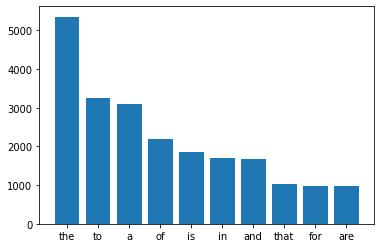

In [10]:
top = sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y = zip(*top)
plt.bar(x,y)
print("The most popular words, not very importnat we must remove stop words")

('de', 1808)
('que', 1257)
('el', 729)
('la', 582)
('people', 563)
('se', 450)
('virus.', 437)
('en', 434)
('Virus', 422)
('A', 421)
('&amp;', 418)
('vírus', 403)
('es', 378)
('China', 376)
('corona', 363)
('un', 351)
('los', 340)
('las', 331)
('Corona', 321)
('e', 320)


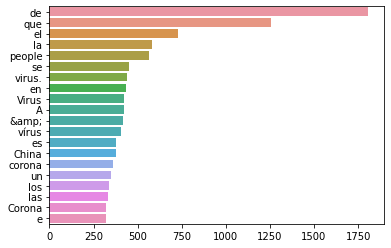

In [11]:
#from collections import  Counter (this is what it is using)
counter = Counter(corpus)
mostCommonWords = counter.most_common()
x, y = [], []

# we have to add the below because ya... we do not want RT -> obs 
stop.add("RT")
stop.add("The")
stop.add("new")
stop.add("-")
stop.add("I")
stop.add(".")
stop.add("virus")
stop.add("http")

#mostCommonWords[:40]

for word, count in mostCommonWords[:60]:
    if (word not in stop):
        x.append(word)
        y.append(count)
sns.barplot (x = y, y = x)

for i in zip(x,y):
    print(i)
    
#https://twitter.com/maddieegwynette?lang=en some random twitter profile...i wonder why this is the case

# Named Entity Recognition

In [12]:
#YOU MUST FIRST RUN THIS COMMAND python3 -m spacy download en_core_web_sm
# nlp = spacy.load("en_core_web_sm") -> this command does not seem to work(stck over flow  and below wrk)
nlp = spacy.load('en')
doc = nlp('South Africa and Canada are going to talk next thursday')
[(x.text,x.label_) for x in doc.ents]
#displacy.render(doc, style='ent')

[('South Africa', 'GPE'), ('Canada', 'GPE'), ('next thursday', 'DATE')]

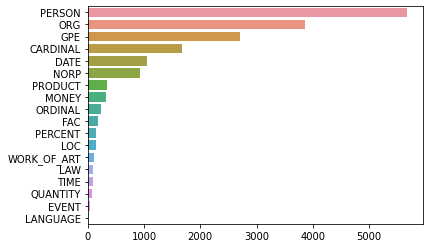

In [13]:
def ner(text):
    doc = nlp(text)
    return [X.label_ for X in doc.ents]

ent = df['full_text'].apply(lambda x : ner(x))
ent = [x for sub in ent for x in sub]
counter = Counter(ent)
counter
count = counter.most_common()
x,y=map(list,zip(*count))
sns.barplot(x=y,y=x)

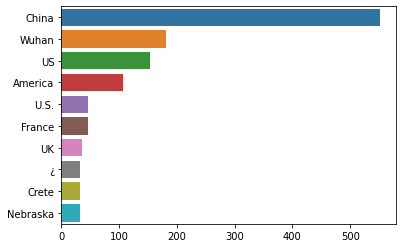

In [14]:
def display(ents):
    def ner(text,ent=ents):
        doc = nlp(text)
        return [X.text for X in doc.ents if X.label_ == ent]

    gpe = df['full_text'].apply(lambda x: ner(x))
    gpe = [i for x in gpe for i in x]
    counter = Counter(gpe)
    x,y=map(list,zip(*counter.most_common(10)))
    sns.barplot(y,x)

display("GPE")
#display("ORG")
#display("PERSON") # this does not work so well, it think corona is a person
#display("CARDINAL")
#display("DATE")
#display("NORP")
#display("MONEY") # nor does this work at all...
#display("LOC")

# Domains

In [15]:
# https://www.geeksforgeeks.org/python-check-url-string/
#GrOss Regex 
def find(string): 
    # findall() has been used  
    # with valid conditions for urls in string 
    regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
    url = re.findall(regex,string)       
    return [x[0] for x in url]
find("I love to use this website when i am working with code https://www.geeksforgeeks.org/python-check-url-string/")
#twitter compressing the URL in their Tweets...
tweet_urls_tiny = []
for i in df['full_text'].values.tolist():
    temp = find(i)
    if temp != []:
        for i in temp:
            tweet_urls_tiny.append(i)
# THIS IS NOT NEEDED AS TWITTER STORES THE DOMAINS IN A FEILD>>>
find("jhkwqjdhkqjwhdqwdjhqwd jqlwdkjqlwkjd https://www.google.com gldglqwdhgqwdqwjdhjwhdqjwhdgqjwhdgqhjwdgqdhjwgjqhwd")

['https://www.google.com']

In [17]:
#https://stackoverflow.com/questions/44113335/extract-domain-from-url-in-python
#https://stackoverflow.com/questions/4201062/how-can-i-unshorten-a-url
#https://www.washingtontimes.com/ is 
def unshorten_url(url):
    parsed = urlp.urlparse(url)
    h = httplib.HTTPConnection(parsed.netloc)
    h.request('HEAD', parsed.path)
    response = h.getresponse()
    if response.status//100 == 3 and response.getheader('Location'):
        return response.getheader('Location')
    else:
        return url

list_df = df["entities"].tolist()
full_urls_list = []
just_domain_name = []
top_pages = []
for i in list_df:
    for j in i["urls"]:
        full_urls_list.append(j["expanded_url"])
        
for i in tqdm(full_urls_list):
    if "twitter" in i:
        continue
    temp = unshorten_url(i)
    just_domain_name.append(urlparse(temp).netloc)
    top_pages.append(temp)
    
counter_domain = Counter(just_domain_name)
counter = Counter(top_pages) 

x,y=map(list,zip(*counter_domain.most_common(20)))
sns.barplot(y,x)

n,c=map(list,zip(*counter.most_common(10)))
for i in zip (n,c):
    print(str(i[1]) + " " + str(i[0])+"\n")   
#x

KeyboardInterrupt: 

# Reading ease 
### not sure how usefull this is

In [ ]:
df["full_text"].apply(lambda x : flesch_reading_ease(x)).hist()
reading = df["full_text"].apply(lambda x : flesch_reading_ease(x))

# POS tagging

In [ ]:
nltk.download('averaged_perceptron_tagger')

In [ ]:
# sentence="The greatest comeback stories in 2019"
# tokens = word_tokenize(sentence)
# nltk.pos_tag(tokens)
# doc = nlp('Corona virus is the worst thing to happen to most people in this world')
# displacy.render(doc, style='dep', jupyter=True, options={'distance': 90})


In [ ]:
def pos(text):
    pos=nltk.pos_tag(word_tokenize(text))
    pos=list(map(list,zip(*pos)))[1]
    return pos

tags = df["full_text"].apply(lambda x : pos(x))
tags = [x for l in tags for x in l]
counter = Counter(tags)

x,y=list(map(list,zip(*counter.most_common(7))))
sns.barplot(x=y,y=x)

In [ ]:
def get_adjs(text):
    adj=[]
    pos=nltk.pos_tag(word_tokenize(text))
    for word,tag in pos:
        if tag=='NN':
            adj.append(word)
    return adj

words = df["full_text"].apply(lambda x : get_adjs(x))
words = [x for l in words for x in l]
counter = Counter(words)

x,y=list(map(list,zip(*counter.most_common(7))))
sns.barplot(x=y,y=x)

In [ ]:
count_machine = Counter([x for l in df['full_text'].str.split().tolist() for x in l])
print("There are "+str(len(count_machine.keys()))+" Unique words*")

# Topic modeling

In [18]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/tomashegewisch/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/tomashegewisch/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [19]:
def preprocess_tweets(df):
    corpus=[]
    
    stem = PorterStemmer()
    lem = WordNetLemmatizer()
    
    for news in df['full_text']:
        words=[w for w in word_tokenize(news) if (w not in stop)]
        
        words=[lem.lemmatize(w) for w in words if len(w)>2]
        
        corpus.append(words)
    return corpus

corpus = preprocess_tweets(df)
dic = gensim.corpora.Dictionary(corpus)
bow_corpus = [dic.doc2bow(doc) for doc in corpus]

In [20]:
lda_model = gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 4, 
                                   id2word = dic,                                    
                                   passes = 10,
                                   workers = 2)
lda_model.show_topics()

[(0,
  '0.021*"http" + 0.009*"Virus" + 0.006*"que" + 0.006*"vírus" + 0.006*"Chinese" + 0.005*"Fauci" + 0.005*"coronavirus" + 0.005*"não" + 0.004*"drug" + 0.004*"people"'),
 (1,
  '0.029*"que" + 0.008*"http" + 0.007*"vírus" + 0.006*"por" + 0.004*"para" + 0.004*"del" + 0.004*"una" + 0.004*"corona" + 0.003*"los" + 0.003*"con"'),
 (2,
  '0.011*"http" + 0.007*"Virus" + 0.007*"China" + 0.005*"la" + 0.005*"Trump" + 0.004*"President" + 0.004*"coronavirus" + 0.003*"le" + 0.003*"del" + 0.003*"business"'),
 (3,
  '0.009*"people" + 0.007*"n\'t" + 0.005*"..." + 0.005*"China" + 0.004*"like" + 0.004*"http" + 0.004*"amp" + 0.004*"This" + 0.004*"get" + 0.003*"need"')]

In [21]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dic)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.144493  0.003226       1        1  31.741180
0     -0.062031 -0.163207       2        1  23.708010
1     -0.161786  0.096554       3        1  22.669605
2      0.079324  0.063427       4        1  21.881210, topic_info=      Term         Freq        Total Category  logprob  loglift
12     que   977.000000   977.000000  Default  30.0000  30.0000
62    http  1225.000000  1225.000000  Default  29.0000  29.0000
99   Virus   503.000000   503.000000  Default  28.0000  28.0000
67   vírus   412.000000   412.000000  Default  27.0000  27.0000
195  Fauci   177.000000   177.000000  Default  26.0000  26.0000
..     ...          ...          ...      ...      ...      ...
475    say    72.393372   278.361328   Topic4  -5.8667   0.1727
406   They    68.284981   139.625610   Topic4  -5.9251   0.8043
77     los    70.078629   270.856934   Topic4  -5.8992   0.1676
128    amp    67.744469   355.114929   Topic4  -5.9330  -0.1372
70   culpa    65.009277   105.366142   Topic4  -5.9742   1.0366

[277 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
679       1  0.928897        've
679       2  0.064507        've
754       1  0.630012        ...
754       2  0.103952        ...
754       3  0.154353        ...
...     ...       ...        ...
323       4  0.237821      would
884       3  0.977843  yannouDof
978       1  0.845390       year
978       2  0.010979       year
978       4  0.131749       year

[443 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 2, 3])

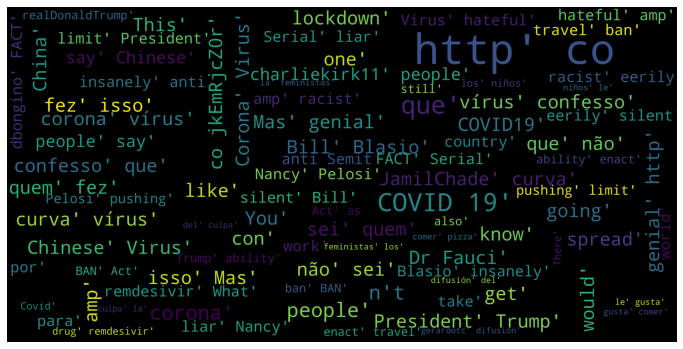

In [22]:
stopwords = set(STOPWORDS) # stop words like and and at will be removed

#so that they do not populate the word cloud
#print(stopwords)
#print(WordCloud.__doc__)
def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords,
        max_words=90,
        max_font_size=25,
        scale=10,
        random_state=1)
    wordcloud = wordcloud.generate(str(data))
    wordcloud.normalize_plurals = True
    #print(type(wordcloud))
    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.show()
show_wordcloud(corpus)

# Devices

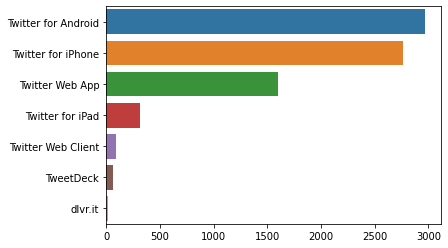

In [23]:
#'<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>'
devices = []
for i in df["source"]:
    soup = BeautifulSoup(i, 'html.parser') 
    devices.append(soup.a.string)
count = Counter(devices)
x,y=list(map(list,zip(*count.most_common(7))))
sns.barplot(x=y,y=x)
# small data set(wonder what a lager set would look like... because its by far iphone(we shoul look at SA and see))

# HashTags

/Users/tomashegewisch/research_project/Tomas/env/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/tomashegewisch/research_project/Tomas/env/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0, flags=flags)


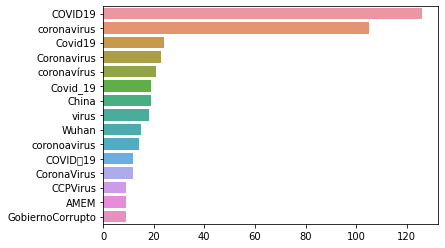

In [24]:
hastags = []
for i in df["entities"].tolist():
    for j in i["hashtags"]:
        #somthing weird happens here 
        try:
            hastags.append(j["text"]) 
        except:
            pass

count = Counter(hastags)
x,y=list(map(list,zip(*count.most_common(15))))
sns.barplot(x=y,y=x)

# Language

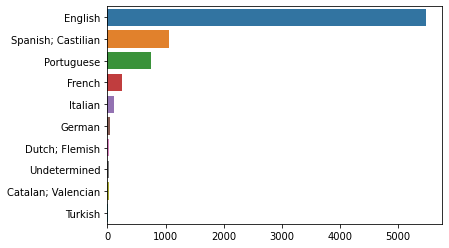

In [32]:
languages = []
for i in df["lang"]:
    try:
        lan = iso639.to_name(i)
        languages.append(lan)
    except:
        pass
        #print("could not find---> "+i)

count = Counter(languages)
x,y=list(map(list,zip(*count.most_common(10))))
sns.barplot(x=y,y=x)
#print(count)

In [26]:
tr= Translator()
tr.translate("vandag gaan die dag wees").text

'Today will be the day'

In [27]:
import iso639
iso639.to_name('sv')
iso639.to_native('sv')

'svenska'

In [ ]:
for i in range(0, len(df)):
    if df["lang"][i] != "en":
        try:
            (tr.translate(df["full_text"][i]).text)
            #print()
            #print(df["full_text"][i])
        except:
            print(" <<< ERRRO :( >>> " +df["full_text"][i])
        print("----")

# Time series

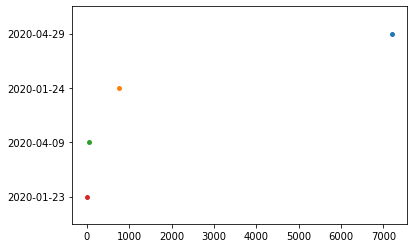

In [28]:
#df.dtypes
dir(sns)
df["created_at"] = pd.to_datetime(df["created_at"])
#df.dtypes
#df['created_at'].plot(linewidth=5)
dates = []
df["created_at"][300].date()

dates = [str(i.date()) for i in df["created_at"]]
count = Counter(dates)
x,y=list(map(list,zip(*count.most_common())))
sns.swarmplot(x=y,y=x)
#sns.kdeplot(y, shade=True);

In [29]:
for i in df["possibly_sensitive"]:
    if i == "True":
        print("Got One")
    else:
        print(i)

nan
nan
nan
nan
False
nan
False
nan
nan
nan
nan
nan
nan
nan
nan
nan
True
nan
nan
nan
nan
nan
nan
nan
nan
nan
False
nan
nan
False
nan
nan
nan
nan
nan
nan
nan
nan
False
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
False
False
nan
False
nan
nan
nan
nan
False
nan
nan
nan
nan
nan
False
nan
nan
nan
nan
nan
nan
nan
nan
nan
False
False
nan
nan
nan
nan
False
nan
nan
nan
nan
nan
nan
False
nan
False
nan
nan
False
nan
nan
nan
False
nan
nan
False
nan
nan
False
False
nan
nan
nan
nan
nan
False
nan
nan
False
nan
nan
nan
False
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
False
nan
nan
nan
nan
nan
nan
nan
nan
False
nan
nan
nan
nan
nan
nan
False
nan
nan
False
nan
nan
False
nan
nan
nan
nan
nan
nan
nan
nan
False
nan
nan
nan
nan
nan
nan
False
nan
nan
nan
nan
nan
nan
nan
nan
nan
False
nan
False
nan
nan
nan
nan
nan
False
nan
nan
nan
False
nan
nan
nan
False
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
False